In [1]:
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt

from src.processing.constants import *
from src.processing.utils import list_files
from src.processing.txt_loading import txt_to_list
from src.processing.radial import radial_select, order_coords, create_radius_select_stack, find_period_radial_select
from src.processing.constants import BUCKLING_PATH, EDGE_TRACKING_PATH
from src.processing.autocorrelation import autocorrelate_single_value, autocorrelate_radial_ring
from src.processing.wrinkle_period import find_period_autocorrelation_fft, periods_from_image, periods_multiple_radii
import pandas as pd

## 1. Setup

In [2]:
bio_image = imread(str(BUCKLING_PATH / "200920_biolight_nobg_nooutliers_despeckle_enhance.tif"))

In [8]:
slice = 100
image = bio_image[slice]

## 2. Analysis

In [9]:
height, width = np.shape(image)
height, width

(1040, 1388)

In [10]:
timestamps_b, radii_b, x_center_b, y_center_b = txt_to_list(str(EDGE_TRACKING_PATH/'200920_biolight_fitted_circle_position_data.txt'))
x_center, y_center = x_center_b[slice], y_center_b[slice]
center_fitted = (x_center, y_center)
coffee_ring_radius = radii_b[0]
coffee_ring_radius

213.617163424972

In [31]:
start, stop = 100, 110
image_array = bio_image[start:stop]
x_centre_array, y_centre_array = x_center_b[start:stop], y_center_b[start:stop]
stack_list = []
for i in range(len(image_array)):
    coord_stack = create_radius_select_stack(image_array[i], (x_centre_array[i], y_centre_array[i]), 300, 0.5)
    data = coord_stack[2]
    stack_list.append(data)

[array([62., 54., 43., ..., 69., 65., 69.]),
 array([54., 54., 51., ..., 65., 54., 54.]),
 array([ 76.,  58.,  40., ..., 106.,  87.,  84.]),
 array([ 76.,  58.,  54., ...,  95., 102.,  95.]),
 array([58., 47., 47., ..., 80., 84., 80.]),
 array([124.,  87.,  62., ...,  98.,  98.,  98.]),
 array([73., 73., 54., ..., 80., 91., 91.]),
 array([73., 69., 62., ..., 98., 98., 98.]),
 array([91., 76., 73., ..., 98., 98., 98.]),
 array([65., 62., 62., ..., 76., 76., 76.])]

In [11]:
stack = create_radius_select_stack(image, center_fitted, 370, 0.5)
data = stack[2]

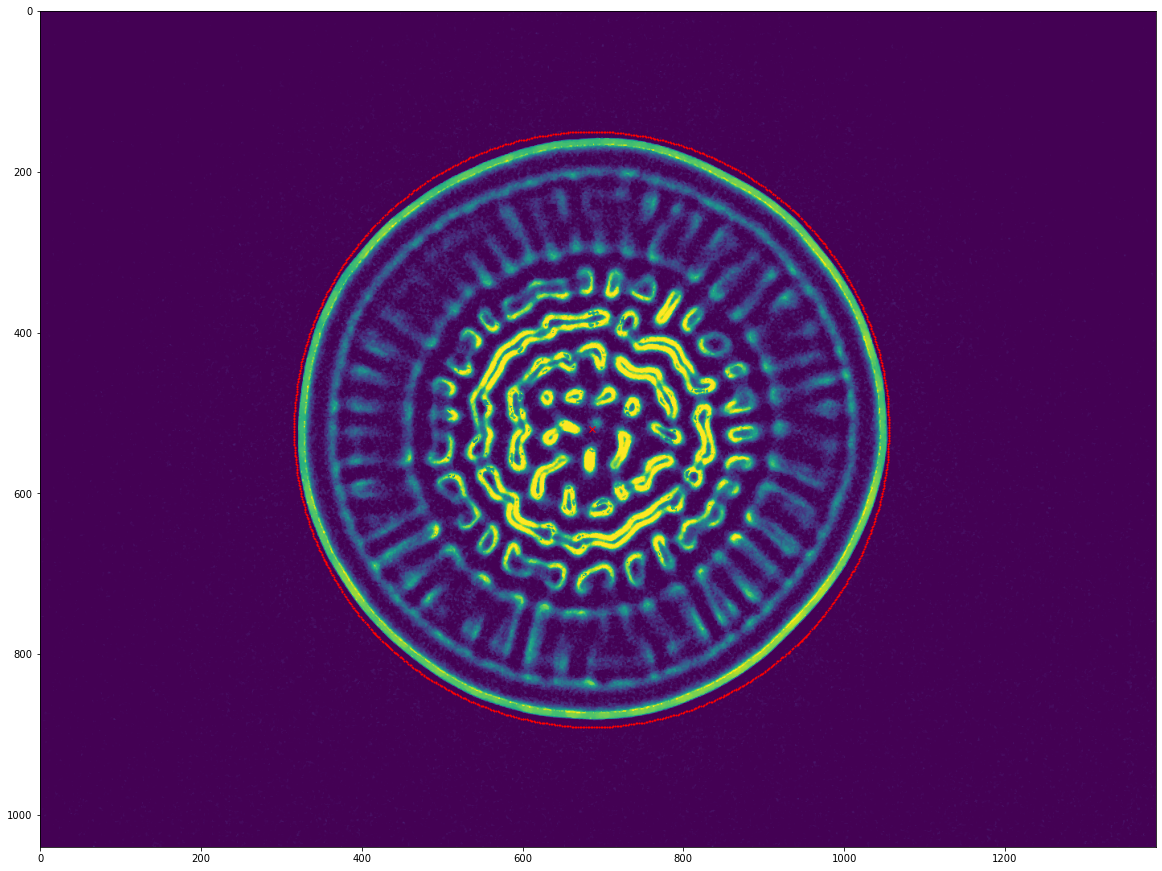

In [12]:
fig, ax = plt.subplots(1,1, figsize=(20, 20))
ax.imshow(image)
ax.plot(x_center, y_center, 'xr')
ax.plot(stack[0][::2], stack[1][::2], 'ro', ms = 1)
ax.set_aspect('equal')
plt.show()

In [15]:
from scipy.signal import find_peaks

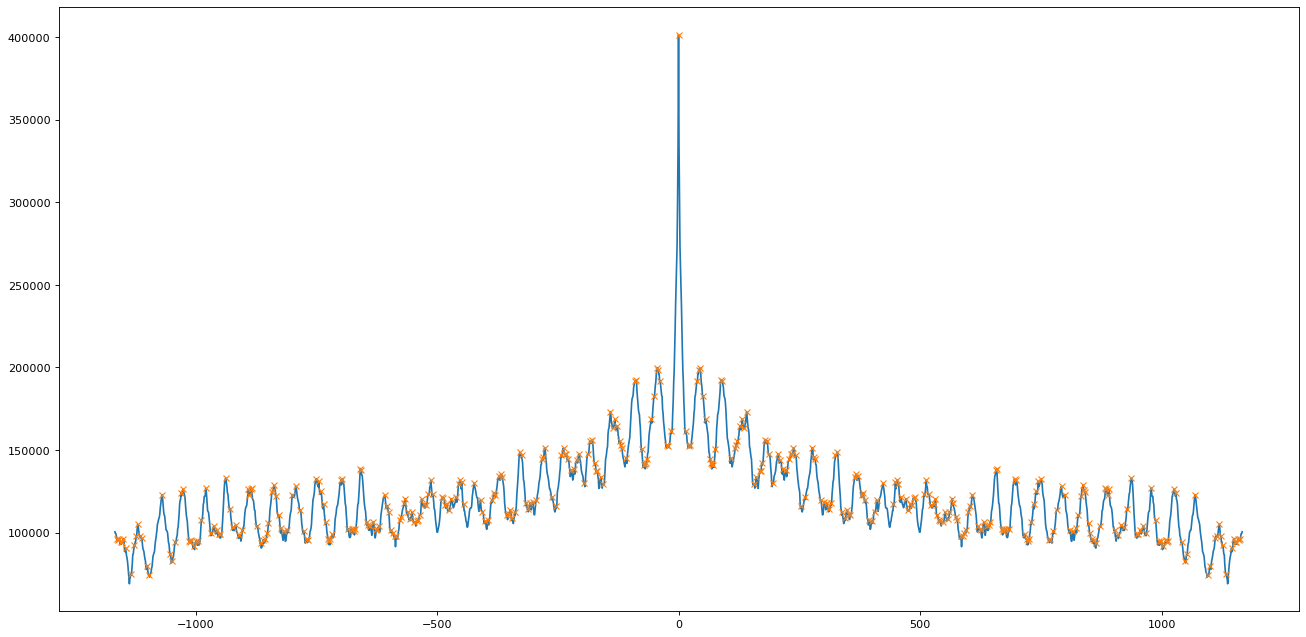

6.706638115631691

In [9]:
def find_period_radial_select(stack, plot=False):
    data = stack[2]
    auto_correlation = np.correlate(data, data, mode='same')
    lags = np.arange(-len(auto_correlation)/2, len(auto_correlation)/2)

    peaks, _ = find_peaks(auto_correlation, height=0)
    second_maximum = np.sort(auto_correlation[peaks])[-2]
    index = np.where(auto_correlation == second_maximum)[0]
    period = (lags[index[1]]/len(data))*360

    if plot == True:
        plt.figure(figsize=(20, 10), dpi=80)
        plt.plot(lags, auto_correlation)
        plt.plot(lags[peaks], auto_correlation[peaks], "x")
        plt.show()
    return period

find_period_radial_select(stack, True)

In [13]:
lags, autocorrelation = autocorrelate_radial_ring(data)

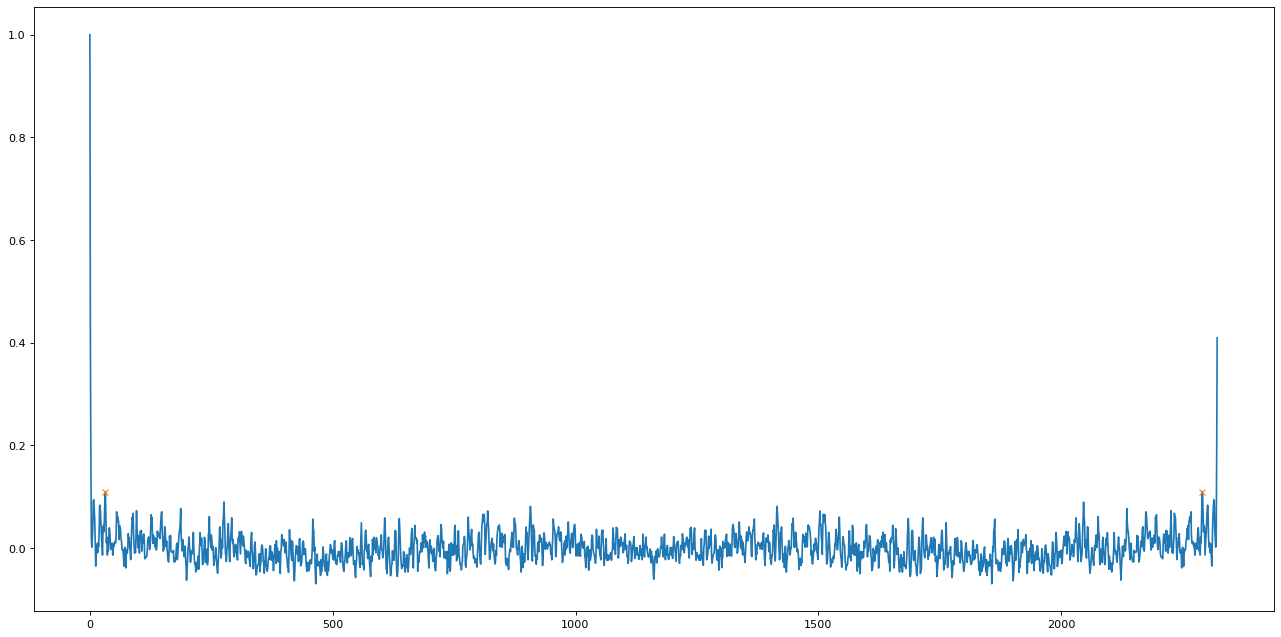

2322

In [16]:
peaks, _ = find_peaks(autocorrelation, height=0.1)

plt.figure(figsize=(20, 10), dpi=80)
plt.plot(lags, autocorrelation)
plt.plot(lags[peaks], autocorrelation[peaks], "x")
plt.show()
len(autocorrelation)


In [17]:
from scipy.ndimage import gaussian_filter

no peaks =  6


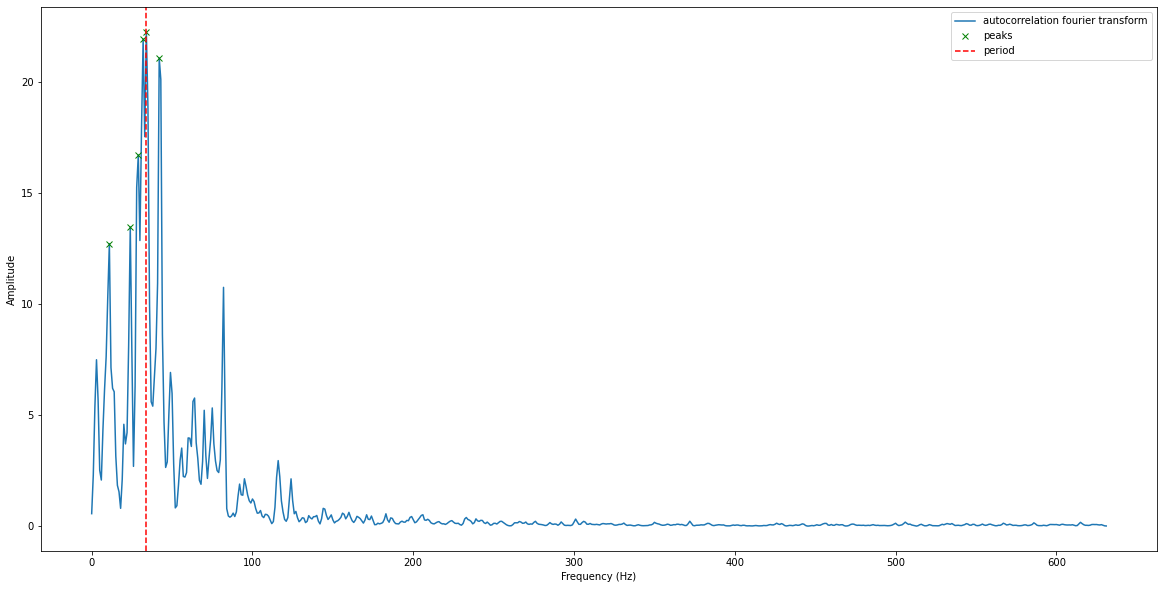

period = 34.0 pixels, 9.691211401425177 degrees
(1,)


In [18]:
image = bio_image[200]
stack = create_radius_select_stack(image, center_fitted,  200, 0.5)
data = stack[2]
lags, autocorrelation = autocorrelate_radial_ring(data)
a, b = find_period_autocorrelation_fft(autocorrelation, 0.8, True)

In [13]:
period_pixels, period_deg = periods_from_image(image, 350, center_fitted)

no peaks =  3
period = 3.0 pixels, 0.4875846501128668 degrees
(1,)


In [18]:
def periods_multiple_radii(image, centre_fitted, start_radius, stop_radius, step, plot=False):
    period  = []
    radii = []
    for r in range(round(start_radius),round(stop_radius), step):
        radii.append(r)
        period_pixels, period_deg = periods_from_image(image, r, centre_fitted)
        period.append(period_deg)
    if plot == True:
        plt.figure(figsize=(20, 10), dpi=80)
    plt.plot(radii, period)
    plt.xlabel('Radius (no.pixels)')
    plt.ylabel('Period (degrees)')


no peaks =  4
period = 13.000000000000002 pixels, 7.452229299363058 degrees
(1,)
no peaks =  2
period = 4.0 pixels, 2.0869565217391304 degrees
(1,)
no peaks =  4
period = 22.0 pixels, 10.588235294117647 degrees
(1,)
no peaks =  2
period = 5.0 pixels, 2.211302211302211 degrees
(1,)
no peaks =  6
period = 16.0 pixels, 6.515837104072399 degrees
(1,)
no peaks =  4
period = 15.0 pixels, 5.678233438485804 degrees
(1,)
no peaks =  5
period = 34.99999999999999 pixels, 12.524850894632204 degrees
(1,)
no peaks =  3
period = 35.0 pixels, 11.666666666666666 degrees
(1,)
no peaks =  11
period = 0 pixels, 0 degrees
(1,)
no peaks =  4
period = 58.0 pixels, 17.575757575757574 degrees
(1,)
no peaks =  6
period = 34.0 pixels, 9.691211401425177 degrees
(1,)
no peaks =  3
period = 44.00000000000001 pixels, 12.018209408194235 degrees
(1,)
no peaks =  1
period = 46.00000000000001 pixels, 11.845493562231761 degrees
(1,)
no peaks =  1
period = 46.0 pixels, 11.412818745692626 degrees
(1,)
no peaks =  1
period 

([100,
  110,
  120,
  130,
  140,
  150,
  160,
  170,
  180,
  190,
  200,
  210,
  220,
  230,
  240,
  250,
  260,
  270,
  280,
  290,
  300,
  310,
  320,
  330,
  340,
  350,
  360,
  370,
  380,
  390],
 [7.452229299363058,
  2.0869565217391304,
  10.588235294117647,
  2.211302211302211,
  6.515837104072399,
  5.678233438485804,
  12.524850894632204,
  11.666666666666666,
  0,
  17.575757575757574,
  9.691211401425177,
  12.018209408194235,
  11.845493562231761,
  11.412818745692626,
  11.01063829787234,
  10.581469648562301,
  10.875462392108508,
  10.632014176018902,
  10.221465076660989,
  10.212765957446809,
  9.303797468354428,
  9.074074074074074,
  9.216867469879517,
  8.729388942774007,
  8.466603951081844,
  8.17810086324398,
  0.31718061674008813,
  7.7519379844961245,
  0,
  0.2954452195322117])

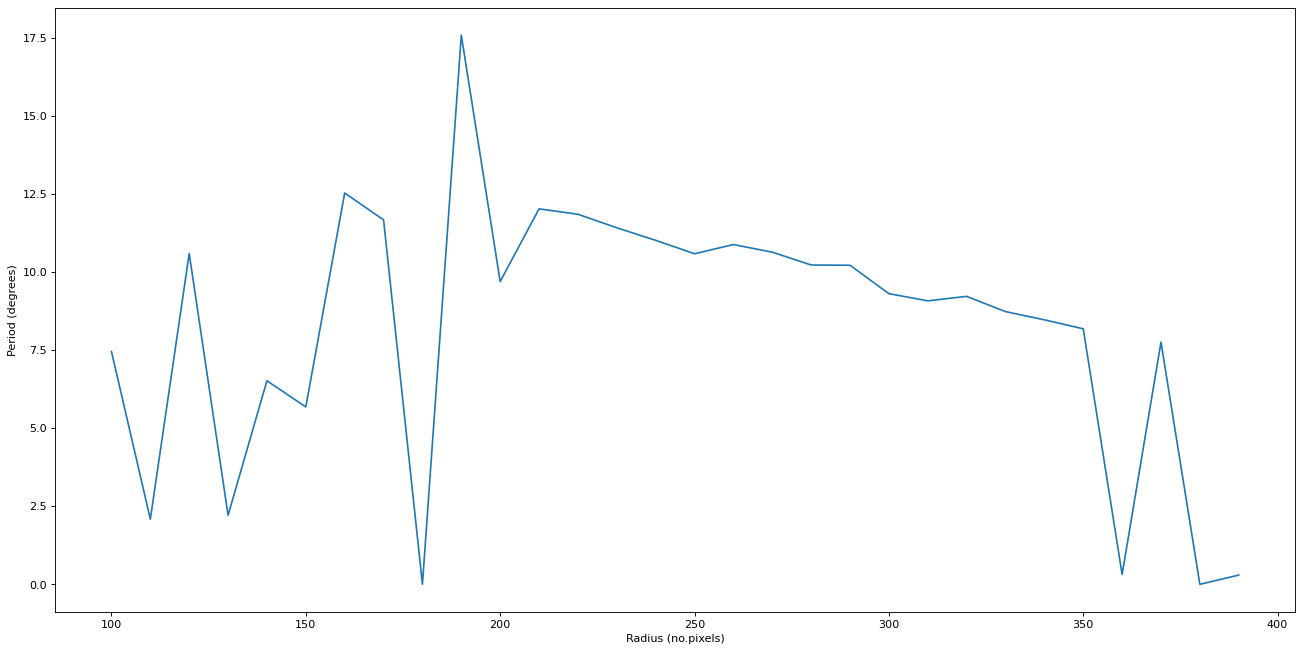

In [19]:
periods_multiple_radii(image, center_fitted, 100, 400, 10, plot=True)

no peaks =  3
period = 38.0 pixels, 10.193740685543965 degrees
(1,)
no peaks =  5
period = 42.0 pixels, 11.402714932126695 degrees
(1,)
no peaks =  5
period = 44.99999999999999 pixels, 11.816192560175054 degrees
(1,)
no peaks =  3
period = 44.0 pixels, 11.81208053691275 degrees
(1,)
no peaks =  2
period = 45.99999999999999 pixels, 12.034883720930232 degrees
(1,)
no peaks =  2
period = 44.00000000000001 pixels, 11.536780772032047 degrees
(1,)
no peaks =  2
period = 42.0 pixels, 11.052631578947368 degrees
(1,)
no peaks =  2
period = 47.0 pixels, 12.111667859699356 degrees
(1,)
no peaks =  2
period = 47.0 pixels, 12.296511627906977 degrees
(1,)
no peaks =  2
period = 48.0 pixels, 12.342857142857143 degrees
(1,)
no peaks =  1
period = 45.99999999999999 pixels, 11.862464183381087 degrees
(1,)
no peaks =  2
period = 47.0 pixels, 12.103004291845494 degrees
(1,)
no peaks =  1
period = 46.0 pixels, 11.564245810055866 degrees
(1,)
no peaks =  1
period = 47.0 pixels, 12.04270462633452 degrees
(1,

Text(0, 0.5, 'Period (degrees)')

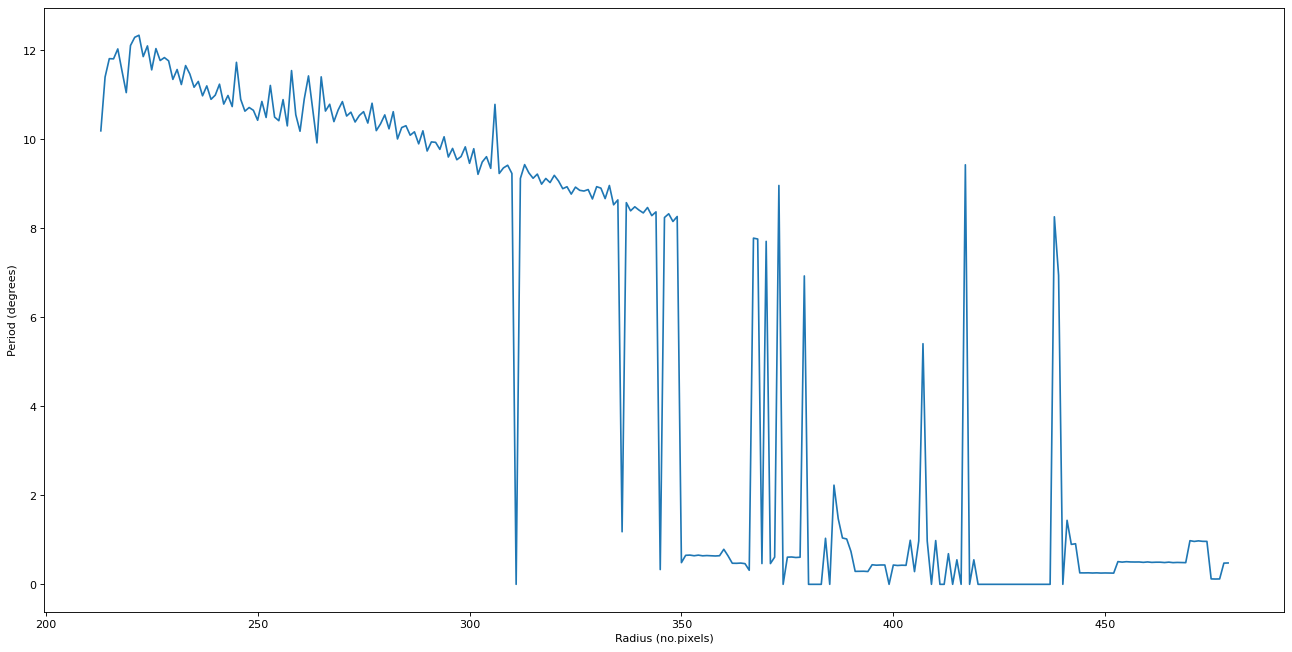

In [85]:
slice_no = 200
image = bio_image[slice_no]
period  = []
radii = []
for r in range(int(coffee_ring_radius),int(radii_b[slice_no])):
    radii.append(r)
    stack = create_radius_select_stack(image, center_fitted,  r, 0.5)
    data = stack[2]
    lags, autocorrelation = autocorrelate_radial_ring(data)
    period_pixels, period_deg = find_period_autocorrelation_fft(autocorrelation, 0.8)
    period.append(period_deg)

plt.figure(figsize=(20, 10), dpi=80)
plt.plot(radii, period)
plt.xlabel('Radius (no.pixels)')
plt.ylabel('Period (degrees)')

Find number of wrinkles

/home/rads/miniconda3/envs/biofilm_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


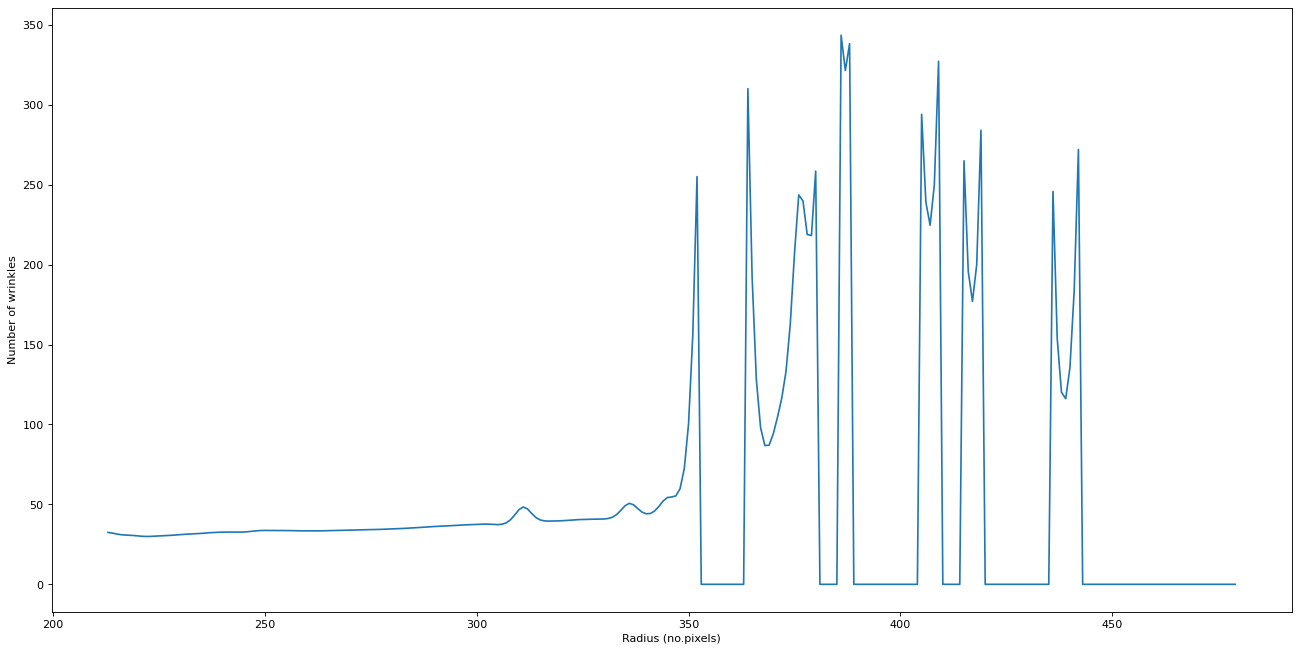

In [86]:
period_smooth = gaussian_filter(period, 2)
period_clipped = np.array(period_smooth)
no_wrinkles = 360/(period_clipped)
no_wrinkles[no_wrinkles > 360] = 0
plt.figure(figsize=(20, 10), dpi=80)
plt.plot(radii, no_wrinkles)
plt.xlabel('Radius (no.pixels)')
plt.ylabel('Number of wrinkles')
plt.show()

Text(0, 0.5, 'Period amoothed (degrees)')

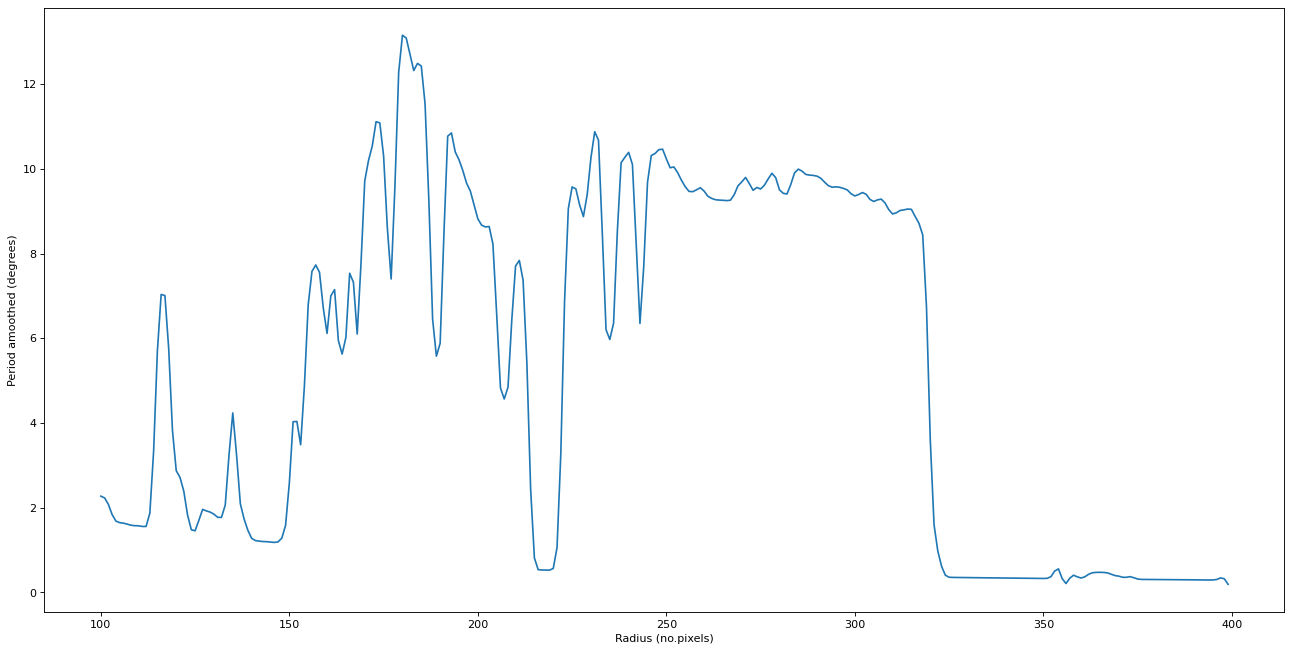

In [172]:
#print(np.shape(np.array(period).flatten()))

period_smooth = gaussian_filter(period, 1)

plt.figure(figsize=(20, 10), dpi=80)
plt.plot(radii, period_smooth)
plt.xlabel('Radius (no.pixels)')
plt.ylabel('Period amoothed (degrees)')

36.5


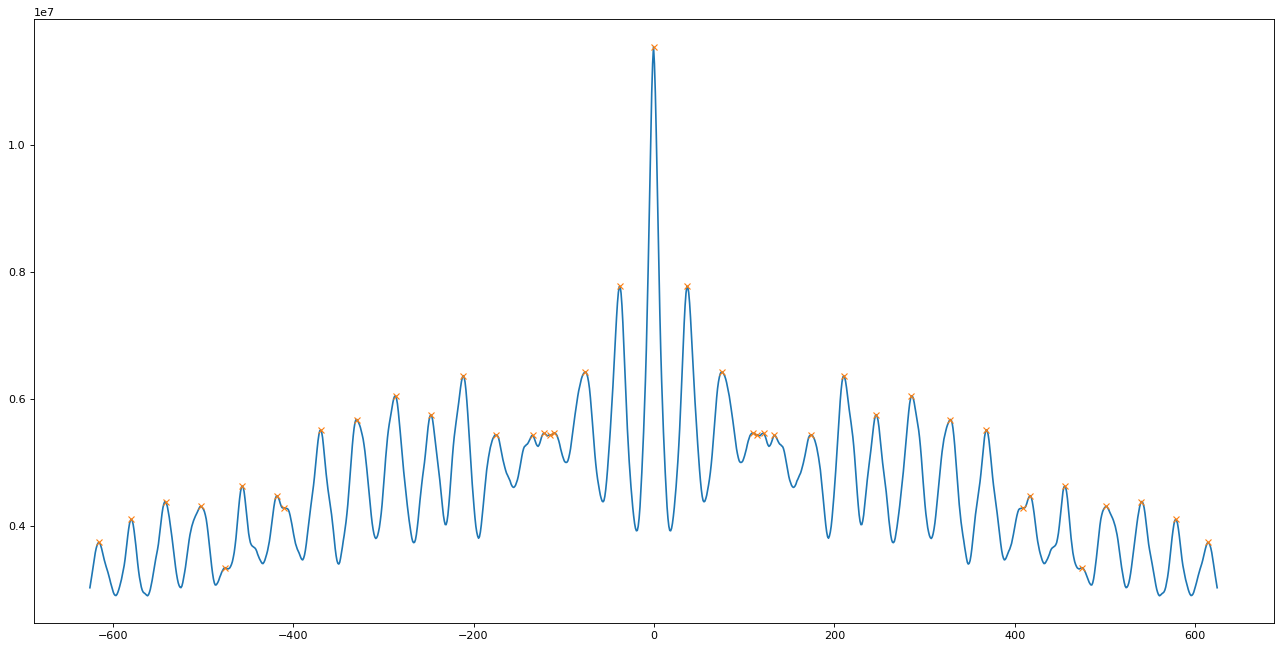

In [ ]:
plt.figure(figsize=(20, 10), dpi=80)
peaks, _ = find_peaks(auto_correlation, height=0)
plt.plot(lags, auto_correlation)
plt.plot(lags[peaks], auto_correlation[peaks], "x")
second_maximum = np.sort(auto_correlation[peaks])[-2]
index = np.where(auto_correlation == second_maximum)[0]
period = lags[index[1]]
print(period)
#plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

The Autocorreleation plot for the data is:


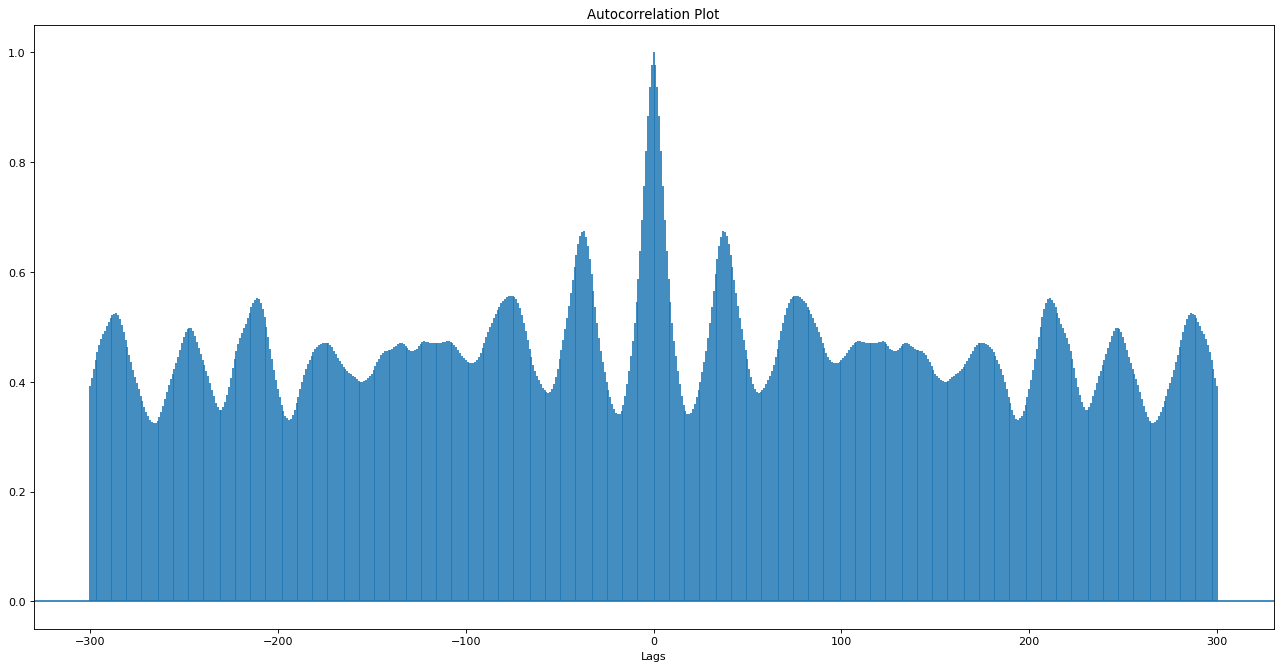

In [ ]:
plt.figure(figsize=(20, 10), dpi=80)
plt.title("Autocorrelation Plot")
plt.xlabel("Lags")
 
# Plotting the Autocorreleation plot.
plt.acorr(data, maxlags = 300)
 
# Displaying the plot.
print("The Autocorreleation plot for the data is:")
#plt.grid(True)
 
plt.show()

In [ ]:
print(len(data))
panda_data = pd.Series(data)
print(len(panda_data))
panda_data.autocorr(750)

762
762


0.8627801959061309

In [ ]:
auto_data = pd.Series([panda_data.autocorr(i) for i in range(0,data.shape[0]-1)], index=range(0,data.shape[0]-1))

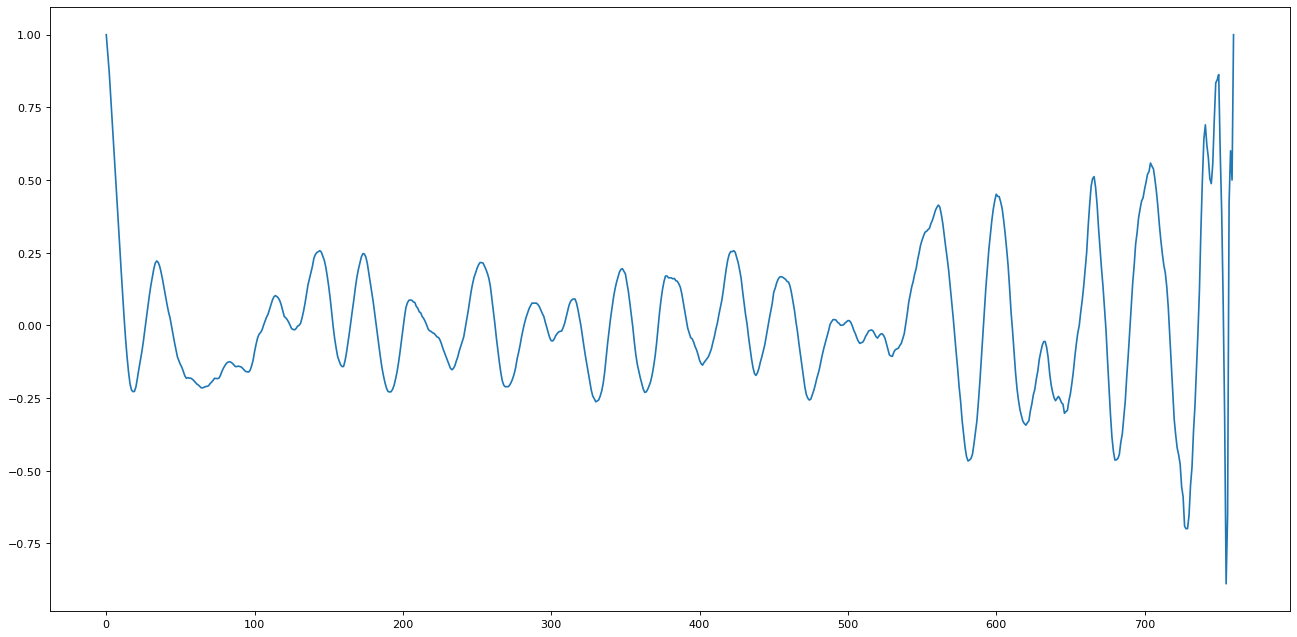

In [ ]:
plt.figure(figsize=(20, 10), dpi=80)
plt.plot(auto_data)